# Day 9: Gradients and Downsampling

##### Goals

- Get a feel for what sorts of operations can be accomplished with linear filtering
- Come up with good gradient operators (Sobel filters)
- Learn how to resize images



In [34]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

# Library imports
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


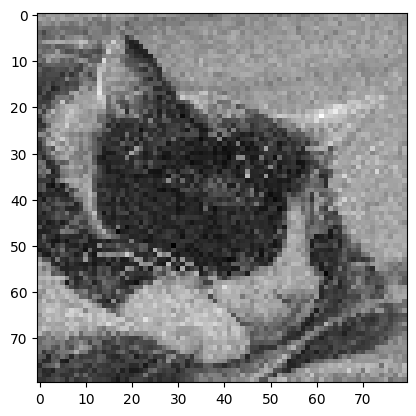

In [35]:
# Sample image to practice with
def getbeans(width=None, sigma=0, imgfile="../data/beans.jpg"):
    beans_bgr = cv2.imread(imgfile)
    beans = cv2.cvtColor(beans_bgr, cv2.COLOR_BGR2GRAY)
    beans = beans.astype(np.float32) / 255.0
    if width is not None:
        height = int(beans.shape[0] * width / beans.shape[1])
        beans = cv2.resize(beans, (width, height))
    if sigma > 0:
        beans = beans + np.random.randn(*beans.shape) * sigma
    return beans

beans = getbeans(width=80, sigma=0.05)
plt.imshow(beans, cmap='gray');

It's easy to filter an image in OpenCV with `cv.filter2D`. What can we do with filtering? 

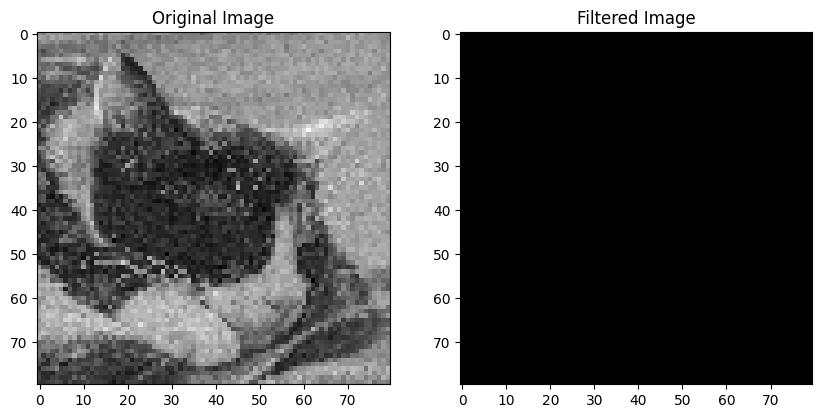

In [36]:
# silly filters
f = np.array(
    [[0, 0, 0],
     [0, 0, 0],
     [0, 0, 0]]
)
# f = np.array(
#     [[0, 0, 0],
#      [0, 1, 0],
#      [0, 0, 0]]
# )
# f = np.ones((5, 5))
# f = np.array(
#     [[0, 0, 0],
#      [1, 0, 0],
#      [0, 0, 0]]
# )
# f = np.array([[0,0,0,0,0,0,0,0,1]])


beans_filtered = cv2.filter2D(src=beans, ddepth=-1, kernel=f, borderType=cv2.BORDER_CONSTANT)
beans_filtered = np.clip(beans_filtered, 0, 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(beans, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(beans_filtered, cmap='gray')
ax[1].set_title('Filtered Image');

OpenCV lets you choose how to handle borders. The [documentation](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_basic_ops/py_basic_ops.html#making-borders-for-images-padding) is a bit hard to find.

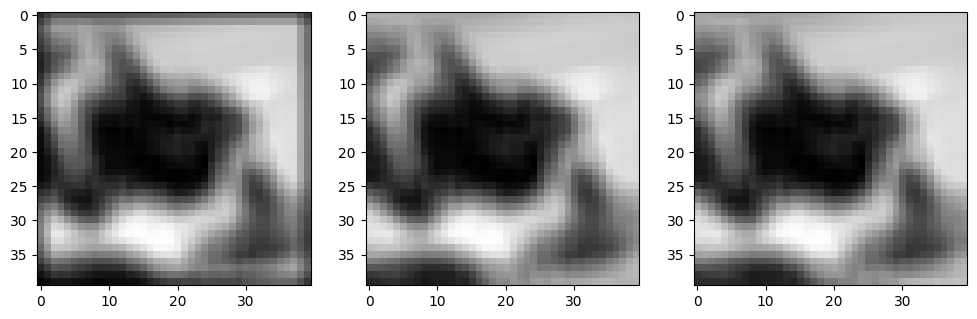

In [37]:
border_types = [cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, cv2.BORDER_REFLECT]

# box averaging 
f = np.ones((5, 5)) / 25.0
# f = np.array([[0,0,0,0,0,0,0,1]])

beans = getbeans(width=40)
fig, axarr = plt.subplots(1, len(border_types), figsize=(12, 4))
for i, border_type in enumerate(border_types):
    beans_filtered = cv2.filter2D(src=beans, ddepth=-1, kernel=f, borderType=border_type)
    beans_filtered = np.clip(beans_filtered, 0, 1)
    axarr[i].imshow(beans_filtered, cmap='gray')
plt.show()

### Useful filters: Gradients, blurs, sharpening

In [38]:
# 2D Gaussian filter
gauss1d = cv2.getGaussianKernel(ksize=5, sigma=1)
gauss2d = gauss1d @ gauss1d.T  # outer product

beans = getbeans(width=20, sigma=0.02) # a little noise
beans_blurred = cv2.filter2D(src=beans, ddepth=-1, kernel=gauss2d, borderType=cv2.BORDER_REPLICATE)
# but this is more efficient:
# beans_blurred = cv2.GaussianBlur(src=beans, ksize=(5, 5), sigmaX=1, borderType=cv2.BORDER_REPLICATE)

Let's work towards edge detection. Let's write an *image derivative* kernel.

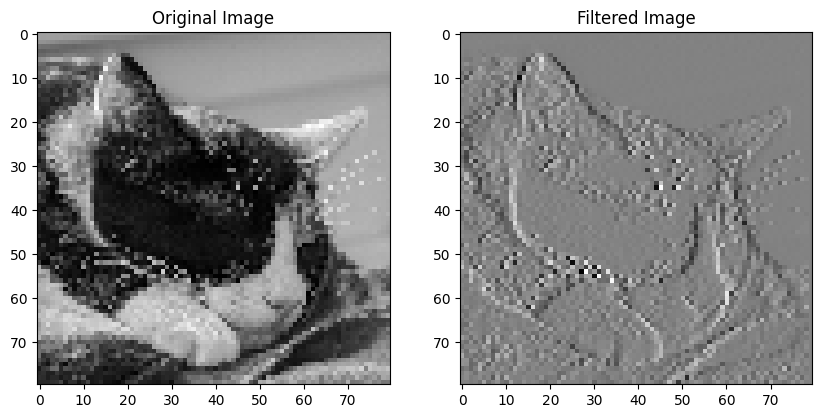

In [39]:
# why doesn't it need to be square?
# (we still like odd-sized kernels though)
kernel = np.array([[0, 1, -1]])

# what about this?
# kernel = np.array([[1, 0, -1]]) 

beans = getbeans(width=80, sigma=0) # no noise
beans_filtered = cv2.filter2D(src=beans, ddepth=-1, kernel=kernel, borderType=cv2.BORDER_REPLICATE)
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(beans, cmap='gray')
axarr[0].set_title('Original Image')
axarr[1].imshow(beans_filtered, cmap='gray')
axarr[1].set_title('Filtered Image');

# That was an x-axis derivative.
# What about y derivatives?


Fun math fact: differentiating white noise doesn't work very well. See what happens with beans:

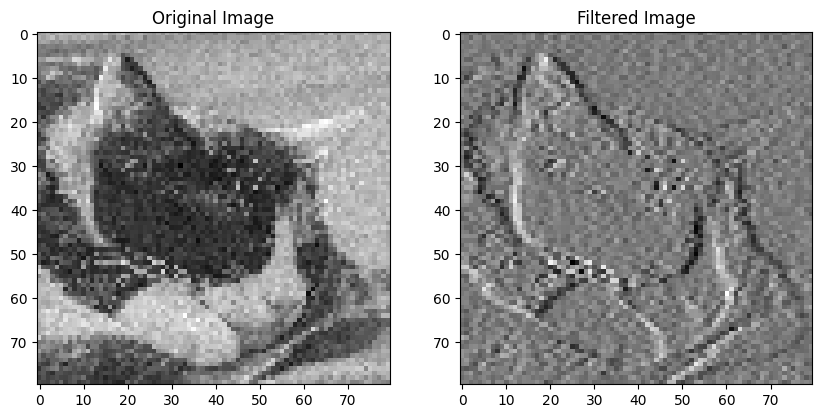

In [40]:
kernel = np.array([[1, 0, -1]]) 

beans = getbeans(width=80, sigma=0.05) # moderate noise
beans_filtered = cv2.filter2D(src=beans, ddepth=-1, kernel=kernel, borderType=cv2.BORDER_REPLICATE)
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(beans, cmap='gray')
axarr[0].set_title('Original Image')
axarr[1].imshow(beans_filtered, cmap='gray')
axarr[1].set_title('Filtered Image');

Noise and edges look the same to our derivative filter. 

Idea: blur a little first, and then take a derivative.

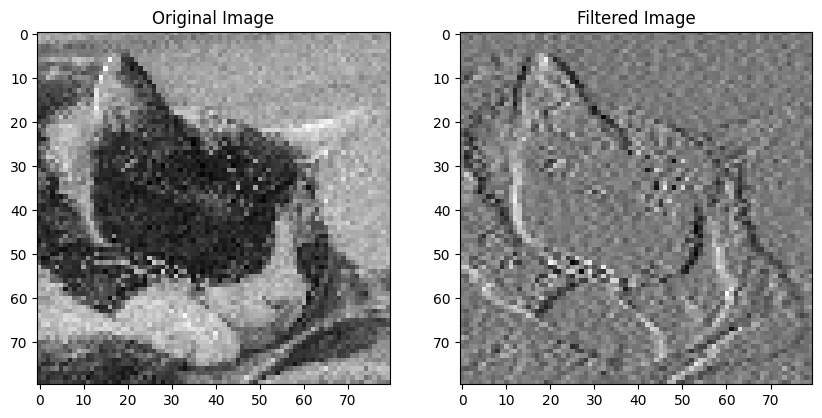

In [41]:
blur_kernel = np.array(
    [[1, 2, 1],
     [2, 4, 2],
     [1, 2, 1]]
) / 16.0
dx_kernel = np.array([[1, 0, -1]]) 

beans = getbeans(width=80, sigma=0.05) # moderate noise
beans_blur = cv2.filter2D(src=beans, ddepth=-1, kernel=kernel, borderType=cv2.BORDER_REPLICATE)
beans_dx = cv2.filter2D(src=beans_blur, ddepth=-1, kernel=dx_kernel, borderType=cv2.BORDER_REPLICATE)
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(beans, cmap='gray')
axarr[0].set_title('Original Image')
axarr[1].imshow(beans_filtered, cmap='gray')
axarr[1].set_title('Filtered Image');

In [42]:
sobel_x = cv2.filter2D(blur_kernel, -1, dx_kernel, borderType=cv2.BORDER_CONSTANT)
print(sobel_x)

[[-0.125  0.     0.125]
 [-0.25   0.     0.25 ]
 [-0.125  0.     0.125]]


Often, the Sobel filters are written like this:

$$ \mathbf{S}_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \\ \end{bmatrix} \quad \mathrm{and} \quad \mathbf{S}_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \\ \end{bmatrix}$$

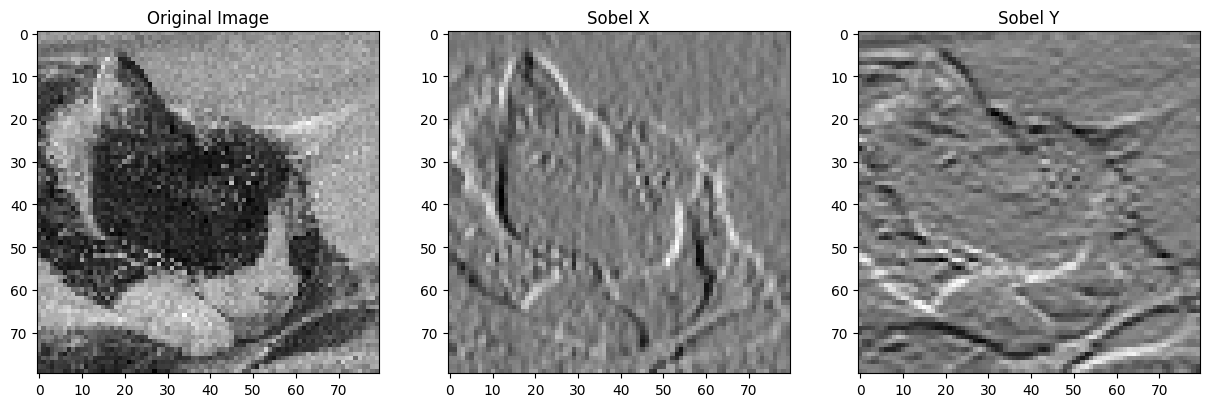

In [43]:
# plot beans with both filters
def plot_sobels(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = sobel_x.T

    # apply filters
    img_sobel_x = cv2.filter2D(src=img, ddepth=-1, kernel=sobel_x, borderType=cv2.BORDER_REPLICATE)
    img_sobel_y = cv2.filter2D(src=img, ddepth=-1, kernel=sobel_y, borderType=cv2.BORDER_REPLICATE)   

    fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
    axarr[0].imshow(img, cmap='gray')
    axarr[0].set_title('Original Image')
    axarr[1].imshow(img_sobel_x, cmap='gray')
    axarr[1].set_title('Sobel X')
    axarr[2].imshow(img_sobel_y, cmap='gray')
    axarr[2].set_title('Sobel Y');  
    plt.show()

beans = getbeans(width=80, sigma=0.05) # moderate noise
plot_sobels(beans)

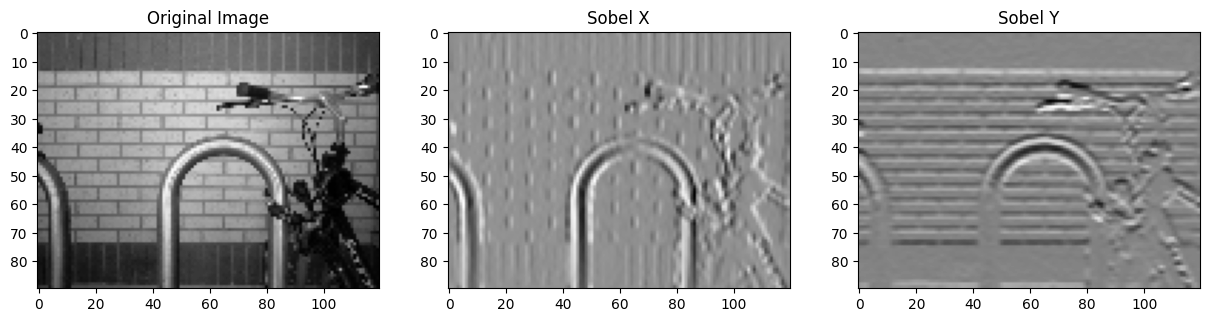

In [44]:
# again, but with a brick wall
imgfile = "../data/bikesgray.jpg"
bricks = getbeans(width = 120, sigma=0, imgfile=imgfile)
plot_sobels(bricks)

What about edges that are oriented at a diagonal?

From calc 3: $$ \nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \\ \end{bmatrix} $$

and the directional derivative in direction $\mathbf{u}$ is $$\nabla f \cdot \mathbf{u} $$

That is, all of the directional information is already present in the $x$ and $y$ partial derivatives.

Clever idea: let's plot the **magnitude** of the gradient vector.

TypeError: Image data of dtype object cannot be converted to float

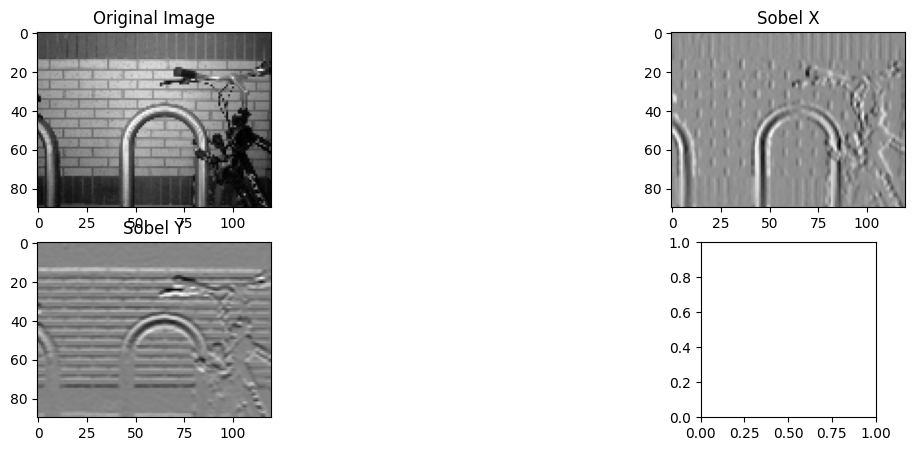

In [45]:
def gradient_magnitude(img_x, img_y):
    img_mag = None # TODO: Write this!
    #
    #
    #
    #
    #
    # 
    return img_mag

def plot_gradient(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = sobel_x.T

    # apply filters
    img_x = cv2.filter2D(src=img, ddepth=-1, kernel=sobel_x, borderType=cv2.BORDER_REPLICATE)
    img_y = cv2.filter2D(src=img, ddepth=-1, kernel=sobel_y, borderType=cv2.BORDER_REPLICATE)  
    img_mag = gradient_magnitude(img_x, img_y)

    fig, axarr = plt.subplots(2, 2, figsize=(15, 5))
    axarr[0,0].imshow(img, cmap='gray')
    axarr[0,0].set_title('Original Image')
    axarr[0,1].imshow(img_x, cmap='gray')
    axarr[0,1].set_title('Sobel X')
    axarr[1,0].imshow(img_y, cmap='gray')
    axarr[1,0].set_title('Sobel Y')
    axarr[1,1].imshow(img_mag, cmap='gray')
    axarr[1,1].set_title('Gradient Magnitude')
    plt.show()

imgfile = "../data/bikesgray.jpg"
bricks = getbeans(width = 120, sigma=0, imgfile=imgfile)
plot_gradient(bricks)

# Last topic: Upsampling and Downsampling

How do we resize an image?

- Easy version (today): 2x bigger or smaller --> fast
- Hard version (later): arbitrary sizes --> slow

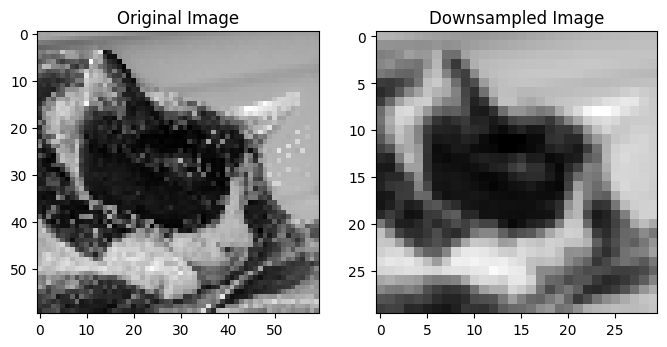

In [ ]:
# downsample image by 2x
beans = getbeans(width=60)
rows, cols = beans.shape
beans_small = beans[::2,::2] # slice with stride 2 in each direction

# here's the OpenCV way. Why does it look so different?
beans_small = cv2.pyrDown(beans, dstsize=(math.ceil(cols/2), math.ceil(rows/2)))

fig, axarr = plt.subplots(1, 2, figsize=(8, 5))
axarr[0].imshow(beans, cmap='gray')
axarr[0].set_title('Original Image')
axarr[1].imshow(beans_small, cmap='gray')
axarr[1].set_title('Downsampled Image')
plt.show()

Nyquist - Shannon theorem:

Downsampling a discrete signal reduces dimensionality. Low-frequency signals can be represented in the smaller image. Higher frequency signals can't be represented. When downsampling naively, all the information that should have been lost by downsampling gets scattered into lower frequencies. This is called "aliasing" and it's a type of data correction.

**Plan:** the right way to downsample:

1. blur out the high frequency info
1. downsample as before

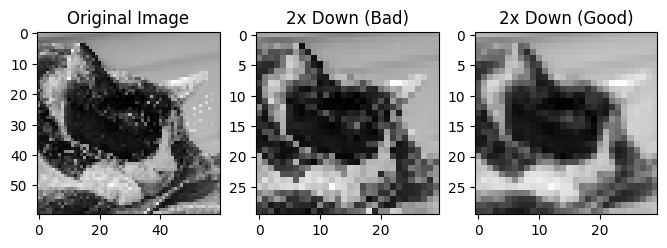

In [48]:
beans = getbeans(width=60)
beans_blurred = cv2.GaussianBlur(src=beans, ksize=(3, 3), sigmaX=1, borderType=cv2.BORDER_REPLICATE)
rows, cols = beans.shape
beans_small_bad = beans[::2,::2] # slice with stride 2 in each direction
beans_small_good = beans_blurred[::2,::2] # slice with stride 2 in each direction

fig, axarr = plt.subplots(1, 3, figsize=(8, 5))
axarr[0].imshow(beans, cmap='gray')
axarr[0].set_title('Original Image')
axarr[1].imshow(beans_small_bad, cmap='gray')
axarr[1].set_title('2x Down (Bad)')
axarr[2].imshow(beans_small_good, cmap='gray')
axarr[2].set_title('2x Down (Good)')
plt.show()

## Last topic: upsampling

(I don't think there will be time for this. If there is, code it below!)